# Credits

This is heavily influenced from https://github.com/pytorch/tutorials

# CIFAR-10

In thins notebook you need to put what you have learned into practice, and create your own convolutional classifier for the CIFAR-10 dataset.

It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’.
The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

![cifar10](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/cifar10.png?raw=1)


In order to train a classifier the following steps needs to be performed:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

We will help you along the way.
We indicate the places you need to modify the code with `# Your code here!`.
It is however a good idea to read the entire assignment before you begin coding!

## 1. Loading and normalizing CIFAR10

Using ``torchvision``, it’s extremely easy to load CIFAR10.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1]

**NB** Modify the code below to only use a small part of the dataset if your computer is very slow.

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5),
                          (0.5, 0.5, 0.5))]
)

# Load dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

used_categories = range(len(classes))

## USE CODE BELOW IF YOUR COMPUTER IS TOO SLOW
reduce_dataset = False
if reduce_dataset:
    used_categories = (3, 5, 6) # cats and dogs

    classes = [classes[i] for i in used_categories]
    new_train_data = []
    new_train_labels = []

    new_test_data = []
    new_test_labels = []
    for i, t in enumerate(used_categories):
        new_train_data.append(trainset.data[np.where(np.array(trainset.targets) == t)])
        new_train_labels += [i for _ in range(new_train_data[-1].shape[0])]

        new_test_data.append(testset.data[np.where(np.array(testset.targets) == t)])
        new_test_labels += [i for _ in range(new_test_data[-1].shape[0])]

    new_train_data = np.concatenate(new_train_data, 0)
    trainset.train_data = new_train_data
    trainset.train_labels = new_train_labels

    new_test_data = np.concatenate(new_test_data, 0)
    testset.test_data = new_test_data
    testset.test_labels = new_test_labels

    
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=True, num_workers=2)
train_data_iter = iter(trainloader)
test_data_iter = iter(testloader)
print('used classes:', classes)

Files already downloaded and verified
Files already downloaded and verified
used classes: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [3]:
print("Training data")
print(trainset.data.shape)
print(len(trainset.targets))
print()

print("Test data")
print(testset.data.shape)
print(len(testset.targets))
print()

Training data
(50000, 32, 32, 3)
50000

Test data
(10000, 32, 32, 3)
10000



Let us show some of the training images, for fun.



 ship  deer truck   dog


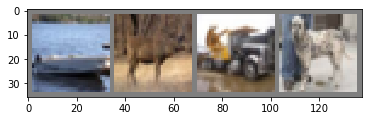

In [4]:
# Run this cell multiple time to see more samples
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    """ show an image """
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
images, labels = train_data_iter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. Define a Convolutional Neural Network

**Assignment 1:** Define a convolutional neural network. 
You may use the code from previous notebooks.
We suggest that you start with a small network, and make sure that everything is working.
Once you can train successfully come back and improve the architecture

In [5]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import torch
import torch.optim as optim
import torch.nn.init as init

input_layers = 3 # We have 3 colors
width = 32
height = 32

classes_num = 10 # len(used_categories) # can be 2 or 10 (depending on data filtering above)

layer_1_filters = 30 # Number of filters for first layer  # 18 worked fine 
layer_2_filters = 36
pooling_karnel_1 = 2

hidden_layer_1 = 256
hidden_layer_2 = 128
hidden_layer_3 = 64



class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.num_classes = num_classes
        
        self.conv1 = torch.nn.Conv2d(input_layers, layer_1_filters, kernel_size=3, stride=1, padding=1)
        
        # half the size of image and take the highest value pixel in karnel size radius 
        self.pool = torch.nn.MaxPool2d(kernel_size=pooling_karnel_1, stride=2, padding=0)
        
        self.conv2 = torch.nn.Conv2d(layer_1_filters, layer_2_filters, kernel_size=3, stride=1, padding=1)
        
        #4608 input features, 64 output features (see sizing flow below)
        self.input_features = layer_2_filters * width//pooling_karnel_1 * height//pooling_karnel_1
        hinnden_1_features = hidden_layer_1
        hinnden_2_features = hidden_layer_2
        hinnden_3_features = hidden_layer_3
        
        #64 input features, 10 output features for our 10/2 defined classes
#         self.fc1 = torch.nn.Linear(self.input_features, hinnden_1_features)
#         self.fc2 = torch.nn.Linear(hinnden_1_features, classes_num)
        
        self.W_1 = Parameter(init.xavier_normal_(torch.Tensor(hinnden_1_features, self.input_features)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(hinnden_1_features), 0))
        # hidden layer 2
        self.W_2 = Parameter(init.xavier_normal_(torch.Tensor(hinnden_2_features, hinnden_1_features)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(hinnden_2_features), 0))
        # hidden layer 3
        self.W_3 = Parameter(init.kaiming_normal_(torch.Tensor(hinnden_3_features, hinnden_2_features)))
        self.b_3 = Parameter(init.constant_(torch.Tensor(hinnden_3_features), 0))
        
        self.W_4 = Parameter(init.kaiming_normal_(torch.Tensor(classes_num, hinnden_3_features)))
        self.b_4 = Parameter(init.constant_(torch.Tensor(classes_num), 0))
        
        
        # define activation function in constructor
        self.activation = torch.nn.ReLU()
        # adding dropout
        self.dropout = torch.nn.Dropout(p=0.2, inplace=False)
        self.batchnorm = torch.nn.BatchNorm1d(self.input_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

        
        # activation
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.activation(x)
        
        x = self.pool(x)
        
        x = self.conv2(x)
        
        x = x.view(-1, self.input_features)
        
        # standard ffn network 
        
        # x = self.batchnorm(x)
        
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
        
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        x = self.dropout(x)
        
        x = F.linear(x, self.W_2, self.b_2)
        x = self.activation(x)
        x = self.dropout(x)
        
        x = F.linear(x, self.W_3, self.b_3)
        x = self.activation(x)
        x = self.dropout(x)
        
        x = F.linear(x, self.W_4, self.b_4)
        x = self.activation(x)
        # x = self.activation(x)
        x = F.softmax(x,dim=1) # dim = 1
        # x = F.log_softmax(x, dim=1)
        return x 
    
    
#     def forward(self, x):
        
#         #Computes the activation of the first convolution
#         #Size changes from (3, 32, 32) to (18, 32, 32)
#         x = F.relu(self.conv1(x))
        
#         #Size changes from (18, 32, 32) to (18, 16, 16)
#         x = self.pool(x)
        
#         #Reshape data to input to the input layer of the neural net
#         #Size changes from (18, 16, 16) to (1, 4608)
#         #Recall that the -1 infers this dimension from the other given dimension
#         x = x.view(-1, 18 * 16 *16)
        
#         #Computes the activation of the first fully connected layer
#         #Size changes from (1, 4608) to (1, 64)
#         x = F.relu(self.fc1(x))
        
#         #Computes the second fully connected layer (activation applied later)
#         #Size changes from (1, 64) to (1, 10)
#         x = self.fc2(x)
#         return(x)

net = Net(len(used_categories))
print(net)

Net(
  (conv1): Conv2d(3, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(30, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm): BatchNorm1d(9216, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


## 3. Define a Loss function and optimizer

**Assignment 2:** Implement the criterion and optimizer. 
We suggest Classification Cross-Entropy loss and SGD with momentum.
You might need to experiment a bit with the learning rate.

In [6]:
import torch.optim as optim

# Added momentum to SGD optimizer:
optimizer = optim.SGD(net.parameters(), lr=1e-4, momentum=0.9) # lr=1e-3 works well
criterion = nn.CrossEntropyLoss()


## 4. Train the network

**Assignment 3:** Finish the training loop below. 
Start by using a small number of epochs (e.g. 3).
Even with a low number of epochs you should be able to see results that are better than chance.
When everything is working increase the number of epochs to find out how good your network really is.

In [7]:
# batch_size = 100
num_epochs = 20
losses = []


for epoch in range(num_epochs):  # loop over the dataset multiple times
    net.train()
    running_loss = 0.0
    batch_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)
        

        # zero the parameter gradients
        # forward + backward + optimize
        outputs  = net(inputs)
        
        loss_size = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss_size.backward()
        optimizer.step()
        
        # print statistic
        running_loss += loss_size
        batch_loss += loss_size
#         if i % 100 == 99:    # print every 100 mini-batches
#             print("Working")
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0
    losses.append(batch_loss)
              
    net.eval()
    train_preds, train_targs = [], []
    for i, data in enumerate(testloader, 0):
        
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels)
        
        output = net(inputs)
        preds = torch.max(output, 1)[1]
        
        train_targs += list(labels)
        train_preds += list(preds.data.numpy())
        
#     if epoch % 5 == 0:
#         print("Epoch %2i : Train Loss %f % (
#                 epoch+1, losses[-1]))
    
    
#         # validation
#         total_val_loss = 0
#         for inputs, labels in val_loader:
            
#             #Wrap tensors in Variables
#             inputs, labels = Variable(inputs), Variable(labels)
            
#             #Forward pass
#             val_outputs = net(inputs)
#             val_loss_size = criterion(val_outputs, labels)
#             total_val_loss += val_loss_size.data[0]


# # setting up lists for handling loss/accuracy
# train_acc, train_loss = [], []
# valid_acc, valid_loss = [], []
# test_acc, test_loss = [], []
# cur_loss = 0
# losses = []

# get_slice = lambda i, size: [i*size,(i+1)*size] # range(i * size, (i + 1) * size)

# for epoch in range(num_epochs):
#     # Forward -> Backprob -> Update params
#     ## Train
#     cur_loss = 0
#     net.train()
    
#     inputs, labels = data
#     for i in range(num_batches_train):
#         a,b = get_slice(i, batch_size)
#         inputs, labels = Variable(inputs[a:b]), Variable(labels[a:b])
#         output = net(inputs)
        
# #         # compute gradients given loss
# #         target_batch = Variable(torch.from_numpy(targets_train[slce]).long())
#         # get the inputs
# #         inputs, labels = data

# #         # wrap them in Variable
# #         inputs, labels = Variable(inputs), Variable(labels)

#         batch_loss = criterion(output, target_batch)
#         optimizer.zero_grad()
#         batch_loss.backward()
#         optimizer.step()
        
#         cur_loss += batch_loss   
#     losses.append(cur_loss / batch_size)

#     net.eval()
#     ### Evaluate training
#     train_preds, train_targs = [], []
#     for i in range(num_batches_train):
#         a,b = get_slice(i, batch_size)
#         inputs, labels = Variable(inputs[a:b]), Variable(labels[a:b])
        
#         # get the inputs
#         inputs, labels = data

#         # wrap them in Variable
#         inputs, labels = Variable(inputs), Variable(labels)
        
#         x_batch = Variable(torch.from_numpy(x_train[slce]))
        
#         output = net(x_batch)
#         preds = torch.max(output, 1)[1]
        
#         train_targs += list(targets_train[slce])
#         train_preds += list(preds.data.numpy())
    
#     ### Evaluate validation
#     val_preds, val_targs = [], []
#     for i in range(num_batches_valid):
#         slce = get_slice(i, batch_size)
#         x_batch = Variable(torch.from_numpy(x_valid[slce]))
        
#         output = net(x_batch)
#         preds = torch.max(output, 1)[1]
#         val_preds += list(preds.data.numpy())
#         val_targs += list(targets_valid[slce])

#     train_acc_cur = accuracy_score(train_targs, train_preds)
#     valid_acc_cur = accuracy_score(val_targs, val_preds)
    
#     train_acc.append(train_acc_cur)
#     valid_acc.append(valid_acc_cur)
    
#     if epoch % 10 == 0:
#         print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
#                 epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

print('Finished Training')

[1,  1000] loss: 2.302
[1,  2000] loss: 2.302
[1,  3000] loss: 2.301
[1,  4000] loss: 2.300
[1,  5000] loss: 2.299
[1,  6000] loss: 2.297
[1,  7000] loss: 2.294
[1,  8000] loss: 2.290
[1,  9000] loss: 2.282
[1, 10000] loss: 2.269
[1, 11000] loss: 2.260
[1, 12000] loss: 2.256
[2,  1000] loss: 2.244
[2,  2000] loss: 2.232
[2,  3000] loss: 2.220
[2,  4000] loss: 2.221
[2,  5000] loss: 2.216
[2,  6000] loss: 2.214
[2,  7000] loss: 2.209
[2,  8000] loss: 2.205
[2,  9000] loss: 2.198
[2, 10000] loss: 2.200
[2, 11000] loss: 2.188
[2, 12000] loss: 2.181
[3,  1000] loss: 2.177
[3,  2000] loss: 2.176
[3,  3000] loss: 2.175
[3,  4000] loss: 2.153
[3,  5000] loss: 2.158
[3,  6000] loss: 2.151
[3,  7000] loss: 2.151
[3,  8000] loss: 2.149
[3,  9000] loss: 2.146
[3, 10000] loss: 2.148
[3, 11000] loss: 2.138
[3, 12000] loss: 2.119
[4,  1000] loss: 2.130
[4,  2000] loss: 2.118
[4,  3000] loss: 2.112
[4,  4000] loss: 2.131
[4,  5000] loss: 2.116
[4,  6000] loss: 2.115
[4,  7000] loss: 2.109
[4,  8000] 

## 5. Test the network on the test data

Now we need to check if the network has learnt anything at all.
We will check this by predicting the class label that the neural network outputs, and checking it against the ground truth.
If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

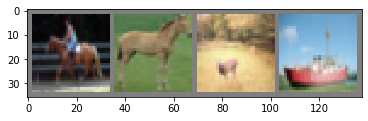

GroundTruth:   horse horse  deer  ship
Predicted:      deer  deer  deer  ship


In [11]:
# testloader = torch.utils.data.DataLoader(testset, batch_size=4,
#                                          shuffle=True, num_workers=2)
# test_data_iter = iter(testloader)
# images, labels = test_data_iter.next()

# print images
imshow(torchvision.utils.make_grid(images))
plt.show()

print('GroundTruth:  ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

_, predicted = torch.max(outputs.data, 1)
print('Predicted:    ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Let us look at how the network performs on the whole dataset.

In [12]:
correct = 0
total = 0

for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
    
print('Accuracy of the network on the {} test images: {:4.2f} %'.format(
    total, 100 * correct / total))

Accuracy of the network on the 10000 test images: 60.00 %


Hopefully the network is better than chance, which is $\frac{1}{\text{number of classes}}$ accuracy (randomly picking
a class).


We can also examine which class the network found the most difficult (makes more sense if you have many clases):

In [13]:
class_total = list(0. for i in range(len(classes)))
class_correct = list(0. for i in range(len(classes)))

for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    
    for i in range(len(c)):
        label = labels[i]
        class_correct[label] += c[i].numpy()
        class_total[label] += 1

for i in range(len(classes)):
    print('Accuracy of {:5s} : {:5.2f} %'.format(
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 64.00 %
Accuracy of car   : 77.20 %
Accuracy of bird  : 42.50 %
Accuracy of cat   : 37.10 %
Accuracy of deer  : 46.40 %
Accuracy of dog   : 46.80 %
Accuracy of frog  : 74.80 %
Accuracy of horse : 68.90 %
Accuracy of ship  : 74.10 %
Accuracy of truck : 68.20 %


**Assignment 4:** 
1. Go back and improve performance of the network. 
 * If you are using all 10 classes you should get a test accuracy above 55%, but see how much further you can get it!
 * If you are using only 2 classes (e.g. cat and dog) you should get a test accuracy above 60%, but see how much further you can get it!

2. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
Did anything surprise you during the exercise?

3. Write down key lessons/insights you got (if any) during this exercise.

**Answer:**

One of the first obsticles was whan I tried working with only two classes (got som wierd error)

First obsticle was when all of the images were clasiffied to be of the same class. I fixed that with making the network bigger/more complex. The effect of learning rate was also very supprising. I also incorporated the dropout to achive faster conversion. Another surprising fact is thah sometimes making lass complex / smaller network impacts the prefoormance in the possitive way. 

Note that every batch needs approximatly 3 min (on my pc), so it teendt to be hard to really modify the network to achive best preformance. 

It took a lot of learning rate tweeking and making the network big enough to achive this 60% accuracy. It coud be made better, but would need more time and computing power.

# Training on GPU

**Optional Assignment:**
If you have a GPU we suggest that you try and rewrite the code above to run on the GPU
___

Just like how you transfer a Tensor on to the GPU, you transfer the neural net onto the GPU.
This will recursively go over all modules and convert their parameters and buffers to CUDA tensors:

```
    net.cuda()
```

Remember that you will have to send the inputs and targets at every step to the GPU too:

```
    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
```

Why dont I notice MASSIVE speedup compared to CPU? 
Because your network is realllly small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images




# Michael Nielsen book exercise of own choice

**Assignment 5:** Pick an exercise of own choice from [Michael Nielsens book](http://neuralnetworksanddeeplearning.com/)

**Answer:**





Exercise: (chapter 1)
There is a way of determining the bitwise representation of a digit by adding an extra layer to the three-layer network above. The extra layer converts the output from the previous layer into a binary representation, as illustrated in the figure below. Find a set of weights and biases for the new output layer. Assume that the first 3 layers of neurons are such that the correct output in the third layer (i.e., the old output layer) has activation at least 0.99, and incorrect outputs have activation less than 0.01.

Answer: 
Yes there is a way. We will represent a set of weights and biases as a matrx: 
The binary representation of nubers will be as follows:
 * 0 -- (0,0,0,0)
 * 1 -- (0,0,0,1)
 * 2 -- (0,0,1,0)
 * ...
 * 9 -- (1,0,0,1)
 
We will put all the biases to be 0 so the biases vector looks like this :
$$b = (0,0,0,0)$$

The weights will be represented as matrix of dimensions $4x10$ (A linear transformation form 10 dimensional space to 4 dimensional space.

$$
\begin{bmatrix}
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 1 \\ 
0 & 0 & 0 & 0 & 1 & 1 & 1 & 1 & 0 & 0 \\ 
0 & 0 & 1 & 1 & 0 & 0 & 1 & 1 & 0 & 0 \\ 
0 & 1 & 0 & 1 & 0 & 1 & 0 & 1 & 0 & 1 
\end{bmatrix}
$$

Whit this we translate the 10 dimensional (10 layer) final output, to 4 layer final output.

For example if we clasify a number as 5, we get $5 = (0,0,0,0,0,1,0,0,0,0)$ and if we translate this with our matrix and our bias vector we get $5 = (0,1,0,1)$